<a href="https://colab.research.google.com/github/ddecosmo-dev/thread-checker/blob/main/threadCheckerTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#import libraries and download testing data from kaggle
#!kaggle datasets download -d devindecosmo/bolt-only-thread-checker-rev-1
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

drive.mount('/content/drive')

# You will be prompted to upload your 'kaggle.json' API key file.
# This only needs to be done once per session.
if not os.path.exists("/root/.kaggle/kaggle.json"):
    from google.colab import files
    print("Please upload your kaggle.json file")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# The name of the main folder that gets created after unzipping
# Change 'training' if your main folder is named something else
dataset_folder = 'Thread Checker Rev 2, bolts only'

if not os.path.exists(dataset_folder):
  print('Dataset not found. Downloading...')
  # Replace with the API command you copied from your dataset's Kaggle page
  !kaggle datasets download -d devindecosmo/thread-checker-bolts-rev2

  # Replace with the actual name of the downloaded .zip file
  !unzip -q thread-checker-bolts-rev2.zip
  print('Download and unzip complete.')
else:
  print('Dataset already exists.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already exists.


In [2]:
#Constants
#data set creation
VALIDATION_SPLIT = 0.2
SEED = 123;

#Data preparation
BATCH_SIZE = 16
#standard is 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

#Model

#Training
EPOCHS = 10
LEARNING_RATE = 0.001


# Define the correct paths to your nested data directories
# Note: This assumes your unzipped folder is named 'Thread Checker Rev 1, bolts only'
TRAIN_DIR = 'Thread Checker Rev 2, bolts only/training'

In [3]:
#Preprocessing bounding box model training
#find a bolt dataset
#train a model to make bounding boxes, and save model, may need to be seperate
#Apply the bounding boxes to each training photo and resave them
#continue as normal

#Easy solution first
import os
from PIL import Image

def crop_to_center_square(image_path, target_size=224):
    """
    Crops an image to its largest possible central square, then resizes it
    to a target square dimension, overwriting the original file.

    Args:
        image_path (str): Path to the image file to be processed.
        target_size (int): The final desired square dimension (e.g., 224).
    """
    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    width, height = img.size
    shortest_side = min(width, height)

    left = (width - shortest_side) / 2
    top = (height - shortest_side) / 2
    right = (width + shortest_side) / 2
    bottom = (height + shortest_side) / 2

    img_cropped = img.crop((left, top, right, bottom))
    img_resized = img_cropped.resize((target_size, target_size), Image.LANCZOS)

    # Overwrite the original file
    img_resized.save(image_path)
    print(f"Processed and overwrote: {image_path}")

def process_directory_tree(root_directory):
    """
    Traverses a directory tree and processes all image files within it.

    Args:
        root_directory (str): The path to the root directory (e.g., 'training').
    """
    if not os.path.isdir(root_directory):
        print(f"Error: Directory not found at {root_directory}")
        return

    print(f"Starting to process images in directory tree: {root_directory}")

    # os.walk() generates the filenames in a directory tree
    for dirpath, dirnames, filenames in os.walk(root_directory):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                crop_to_center_square(file_path)

    print("\nProcessing complete for all images in the directory tree.")

# --- Example Usage ---
# Point the function to your main training folder
root_training_folder = TRAIN_DIR
process_directory_tree(root_training_folder)

Starting to process images in directory tree: Thread Checker Rev 2, bolts only/training
Processed and overwrote: Thread Checker Rev 2, bolts only/training/bolt_0.125in/IMG_20250902_134624211_HDR.jpg
Processed and overwrote: Thread Checker Rev 2, bolts only/training/bolt_0.125in/IMG_20250827_200522935.jpg
Processed and overwrote: Thread Checker Rev 2, bolts only/training/bolt_0.125in/IMG_20250827_200535204.jpg
Processed and overwrote: Thread Checker Rev 2, bolts only/training/bolt_0.125in/IMG_20250902_134526177.jpg
Processed and overwrote: Thread Checker Rev 2, bolts only/training/bolt_0.125in/IMG_20250902_134728085_HDR.jpg
Processed and overwrote: Thread Checker Rev 2, bolts only/training/bolt_0.125in/IMG_20250902_134443391.jpg
Processed and overwrote: Thread Checker Rev 2, bolts only/training/bolt_0.125in/IMG_20250902_134553224_HDR.jpg
Processed and overwrote: Thread Checker Rev 2, bolts only/training/bolt_0.125in/IMG_20250827_200542577.jpg
Processed and overwrote: Thread Checker Rev 

In [4]:
#dataset import and creation
#may need some scaling or bounding box depending on accuracy
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  seed=123,  # The seed ensures the random split is the same every time
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical') # Add this line to get one-hot encoded labels

# We create the validation set from the remaining 20%
val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  seed=123, # Using the same seed is crucial to prevent overlap
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical') # Add this line to get one-hot encoded labels


# Get the class names from the folder structure
class_names = train_ds.class_names
num_classes = len(class_names)
print("Found the following classes:", class_names)

"""
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # Use the label directly as the index
    label_index = labels[i]

    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[label_index])
    plt.axis("off")
plt.show()
"""

Found 348 files belonging to 3 classes.
Using 279 files for training.
Found 348 files belonging to 3 classes.
Using 69 files for validation.
Found the following classes: ['bolt_0.125in', 'bolt_0.25in', 'bolt_0.375in']


'\nplt.figure(figsize=(10, 10))\nfor images, labels in train_ds.take(1):\n  for i in range(9):\n    ax = plt.subplot(3, 3, i + 1)\n\n    # Use the label directly as the index\n    label_index = labels[i]\n\n    plt.imshow(images[i].numpy().astype("uint8"))\n    plt.title(class_names[label_index])\n    plt.axis("off")\nplt.show()\n'

In [5]:
# --- 3. CONFIGURE DATASETS FOR PERFORMANCE ---
# These steps optimize the data pipeline for speed during training.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nDatasets are loaded, prepared, and ready for training.")


Datasets are loaded, prepared, and ready for training.


In [6]:
#data preparation

#resizing

#normalizing

#batching

In [7]:
#feature engineering

In [8]:
#model selection and training
# --- 4. PREPARE THE MODEL (Transfer Learning) ---

# Create a data augmentation layer to prevent overfitting and improve generalization.
#randomly changes the postion and orientation to improve training
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

# Get the specific preprocessing function required for MobileV2
#is this normalization
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Load the pre-trained base model from Keras.
# We freeze its weights so we only train our new final layers.
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False, # Don't include the final ImageNet classifier
                                               weights='imagenet')
base_model.trainable = False # Freeze the convolutional base

# Create our own classification head to place on top of the base model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)      # 1. Apply augmentation
x = Rescaling(1./127.5, offset=-1)(x)            # 2. Preprocess for MobileNetV2
x = base_model(x, training=False)  # 3. Run the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x) # 4. Pool features to a single vector, final layer before final
x = tf.keras.layers.Dropout(0.2)(x) # 5. Add dropout to prevent overfitting, randomly turns off nuerons to improve operability
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # 6. Final prediction layer

# Chain all the pieces together into the final model
model = tf.keras.Model(inputs, outputs)

# Print a summary of the model's architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Compile the model, configuring it for training
#come back and do more research on alternatives, or ways
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


In [10]:
#train model
# Set the number of epochs to train for
# Start the training process

print("Starting model training...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

print("Model training complete.")

Starting model training...
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4024 - loss: 1.1691 - val_accuracy: 0.4638 - val_loss: 1.0312
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5262 - loss: 0.9159 - val_accuracy: 0.5507 - val_loss: 0.9030
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5663 - loss: 0.8893 - val_accuracy: 0.5507 - val_loss: 0.8788
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5653 - loss: 0.8904 - val_accuracy: 0.6087 - val_loss: 0.8240
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5810 - loss: 0.8345 - val_accuracy: 0.7246 - val_loss: 0.7194
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 947ms/step - accuracy: 0.6427 - loss: 0.8347 - val_accuracy: 0.6522 - val_loss: 0.7625
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 916ms/step - accuracy: 0.6369 - loss: 0.7817 - val_accuracy: 0.6522 - val_loss: 0.7868
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 927ms/step - accuracy: 0.7088 - loss: 0.717

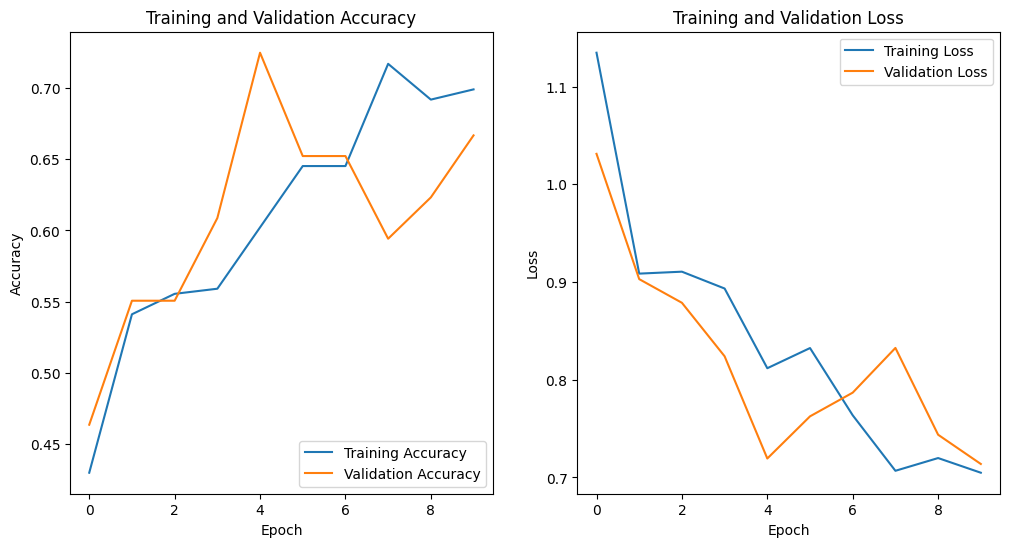

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


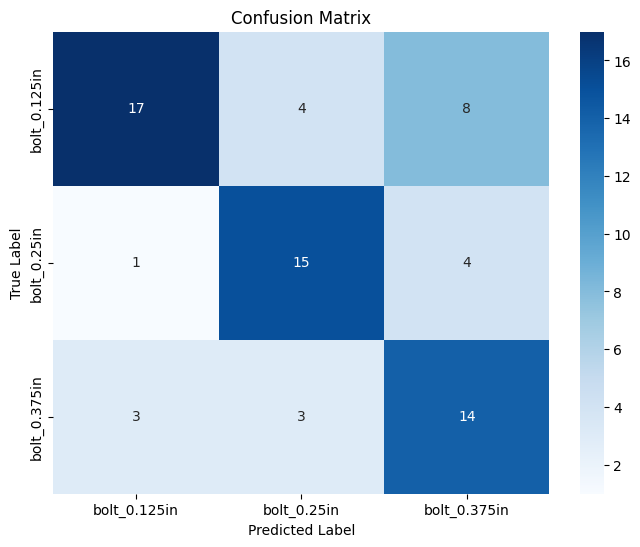

              precision    recall  f1-score   support

bolt_0.125in       0.81      0.59      0.68        29
 bolt_0.25in       0.68      0.75      0.71        20
bolt_0.375in       0.54      0.70      0.61        20

    accuracy                           0.67        69
   macro avg       0.68      0.68      0.67        69
weighted avg       0.69      0.67      0.67        69



In [18]:
#training metrics
# Extract the accuracy history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract the loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(EPOCHS)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

#additional validation stuff to add
#confusion matrices, other parameters
# 1. Get the true labels and predictions from the validation set
y_pred = []  # Store predicted labels
y_true = []  # Store true labels

# Iterate over the validation dataset
for image_batch, label_batch in val_ds:
   # Append true labels
   y_true.extend(np.argmax(label_batch.numpy(), axis=-1))
   # Get model predictions
   preds = model.predict(image_batch)
   # Append predicted labels
   y_pred.extend(np.argmax(preds, axis=-1))

# 2. Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [12]:
#saving trained model for GUI usage

# Define a path in your Google Drive.
# '/content/drive/MyDrive/' is the standard path to your main "My Drive" folder.
model_path = '/content/drive/MyDrive/24-679 AI ML Projects/Project 0/thread_checker_model.keras'

# Save the model to the specified path.
model.save(model_path)

print(f"Model saved to: {model_path}")

Model saved to: /content/drive/MyDrive/24-679 AI ML Projects/Project 0/thread_checker_model.keras


In [13]:
#save a JSON of directory data for GUI
# --- CONFIGURE YOUR PATHS HERE ---
DATASET_PATH = '/content/Thread Checker Rev 1, bolts only/training/' # Path to the dataset
OUTPUT_FILE_PATH = '/content/drive/MyDrive/24-679 AI ML Projects/Project 0/class_map.json' # Output JSON file

# --- SCRIPT TO BUILD THE NESTED MAP ---
class_map = {}
class_index = 0
print(f"Scanning directory: {DATASET_PATH}")

# os.walk goes through every folder and subfolder
for root, dirs, files in os.walk(DATASET_PATH):
    # We are looking for the deepest folders which contain the images
    if not dirs: # If a folder has no subdirectories, it's a leaf folder
        # Get the full path label, like 'bolts/Hex_Bolt_0.25'
        full_label = os.path.relpath(root, DATASET_PATH)

        # This is the unique key your model will be trained to recognize
        # Keras/TF use the full path as the class name in this case
        class_map[full_label] = class_index
        class_index += 1

if not class_map:
    print("WARNING: No leaf directories found. Did not generate a map.")
else:
    # Save the structured dictionary to a JSON file
    with open(OUTPUT_FILE_PATH, 'w') as f:
        json.dump(class_map, f, indent=2)
    print(f"✅ Successfully created class map with {len(class_map)} entries at {OUTPUT_FILE_PATH}")



Scanning directory: /content/Thread Checker Rev 1, bolts only/training/


In [14]:
##fine tuning if desired?
"""
# Unfreeze the base model
base_model.trainable = True

# Re-compile the model with a very low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 10x smaller
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training for a few more epochs
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
"""

"\n# Unfreeze the base model\nbase_model.trainable = True\n\n# Re-compile the model with a very low learning rate\nmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 10x smaller\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\n# Continue training for a few more epochs\nfine_tune_epochs = 10\ntotal_epochs = epochs + fine_tune_epochs\n\nhistory_fine = model.fit(train_ds,\n                         epochs=total_epochs,\n                         initial_epoch=history.epoch[-1],\n                         validation_data=val_ds)\n"